In [1]:
import json
import ast
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder

from config import Config, MulticlassConfig
from preprocessing import (
    build_vocab, save_vocab, load_vocab,
    build_scaler, save_scaler, load_scaler,
    build_label_encoder, save_label_encoder, load_label_encoder,
    MalwareDataset
)
from model import BiLSTM
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
ARTIFACT_DIR = "artifacts"
VOCAB_PATH = os.path.join(ARTIFACT_DIR, "vocab.pkl")
label_ENCODER_PATH = os.path.join(ARTIFACT_DIR, "label_encoder.pkl")

In [3]:
mode = int(input("Pilih mode (1=binary, 2=multiclass): "))

if mode == 1:
    cfg = Config()
    model_name = "binary_model.pth"
    data_files = [
        "benign.csv",
        "fitur_Malware.csv",
        "Coinminer.csv",
        "RAT.csv",
        "Trojan.csv",
        "Cryptominer.csv",
        "Ransomware.csv"
        ]
    file_label_map = {
        "benign.csv": 0,
        "fitur_Malware.csv": 1,
        "Coinminer.csv":1,
        "RAT.csv":1,
        "Trojan.csv":1,
        "Cryptominer.csv":1,
        "Ransomware.csv":1
    }
    SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler_binary.pkl")
    print("Mode: binary")
elif mode == 2:
    cfg = MulticlassConfig()
    model_name = "multiclass_model.pth"
    data_files = [
        "Coinminer.csv",
        "RAT.csv",
        "Trojan.csv",
        "Cryptominer.csv",
        "Ransomware.csv"
    ]
    file_label_map = {
        fname: os.path.splitext(fname)[0].lower()
        for fname in data_files
    }
    SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler_multi.pkl")
    class_names = sorted(set(file_label_map.values()))
    le = LabelEncoder().fit(class_names)          # <— encoder string
    save_label_encoder(le, label_ENCODER_PATH)
    print("Mode: multiclass")

max_len = cfg.max_length
batch_size = cfg.batch_size
epochs = cfg.epochs
lr = cfg.learning_rate
MODEL_PATH = os.path.join(ARTIFACT_DIR, model_name)


Mode: binary


In [4]:
df_list = []
for fname in data_files:
    df_i = pd.read_csv(fname)
    df_i["label"] = file_label_map[fname]
    df_list.append(df_i)
df = pd.concat(df_list, ignore_index=True)

if mode == 2:
    merge_mapping = {
        "coinminer": "cryptominer",
        "rat": "trojan"
    }
    df['label'] = df['label'].replace(merge_mapping).str.lower()
    print(df['label'].value_counts())
    le = build_label_encoder(df['label'])     # <- df['label'] masih STRING
    save_label_encoder(le, label_ENCODER_PATH)
    df['y'] = le.transform(df['label'])       # 0..n-1
    cfg.num_classes = len(le.classes_)


In [5]:
# sequence_cols = [c for c in df.columns if c.endswith('_seq')] # Ambil kolom yang berakhiran _seq
sequence_cols = [
        'exec_processes_seq', 'exec_paths_seq', 'dns_queries_seq',
        'udp_ports_seq', 'hosts_seq', 'sig_names_seq'
    ]
for col in sequence_cols: # Konversi string ke list
    df[col] = df[col].apply(
        lambda x: ast.literal_eval(x)
                  if isinstance(x, str) and x.startswith('[')
                  else x
                  if isinstance(x, (list, np.ndarray))
                  else []
    )

df['combined_seq'] = ( # Gabungkan semua sequence columns menjadi satu string
    df[sequence_cols]
      .apply(lambda row: ";".join(str(token)
                                  for c in sequence_cols
                                  for token in row[c]), axis=1)
)

def extract_stats(s): # Fungsi untuk menghitung total, unik, dan diversity dari sequence
    toks      = s.split(';') if s else []
    total     = len(toks)
    unique    = len(set(toks))
    diversity = unique/total if total>0 else 0
    return total, unique, diversity

df[['seq_length','seq_unique_count','seq_diversity']] = ( 
    df['combined_seq']
      .apply(lambda s: pd.Series(extract_stats(s)))
)

if mode == 2:
    df['label_enc'] = LabelEncoder().fit_transform(df['label'])
else:
    classes = sorted(df['label'].unique())
    df['label_enc'] = df['label'].map({c:i for i,c in enumerate(classes)})

seq_len_df = df[sequence_cols].applymap(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else 0)

corrs_seq = seq_len_df.corrwith(df['label_enc'])

print("Sequence columns ↔ label correlations:")
print(corrs_seq)



Sequence columns ↔ label correlations:
exec_processes_seq    0.203069
exec_paths_seq        0.203069
dns_queries_seq       0.321392
udp_ports_seq         0.191547
hosts_seq             0.019153
sig_names_seq         0.607689
dtype: float64


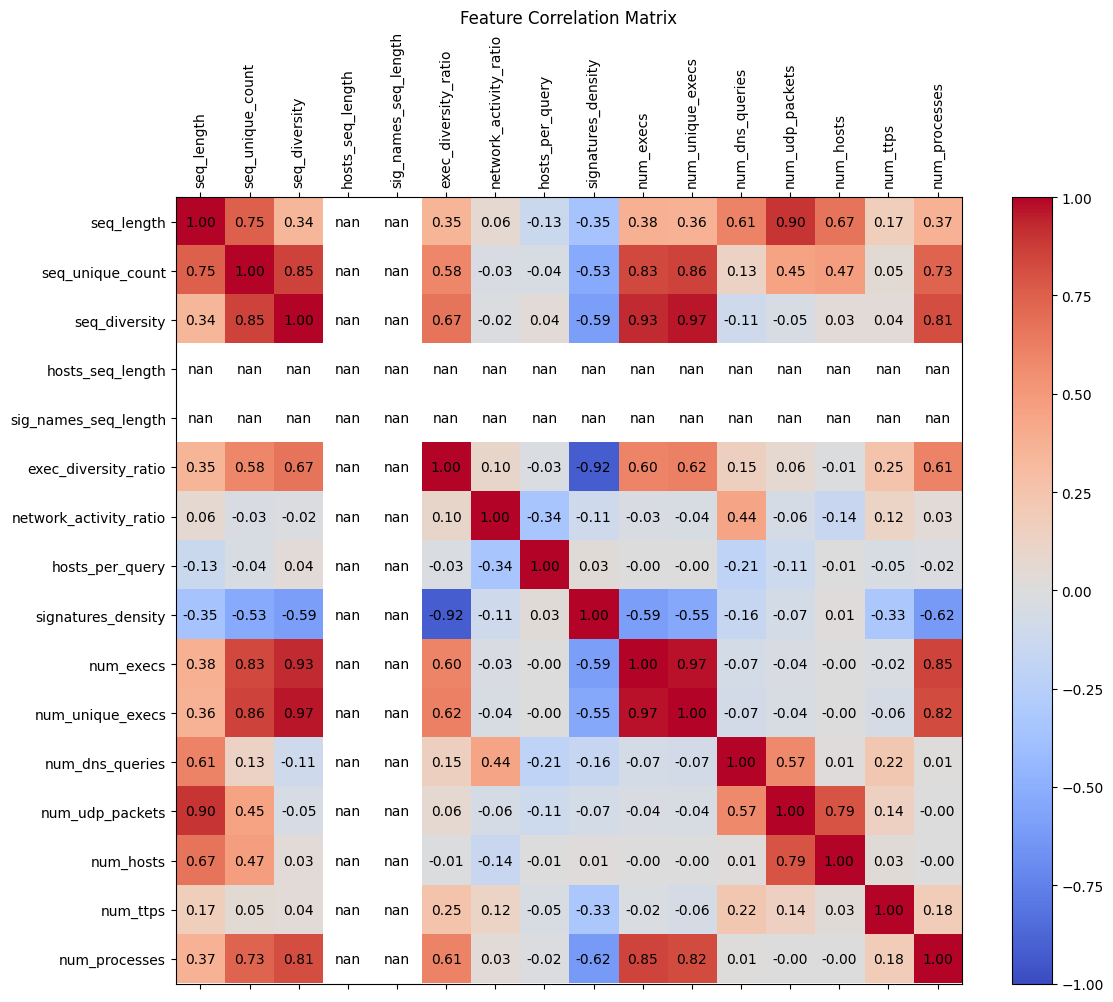

In [6]:
numeric_cols = [c for c in df.columns if c.startswith('num_')]

df[numeric_cols] = df[numeric_cols].fillna(0)

df['hosts_seq_length'] = df['hosts_seq'].astype(str).str.split(';').str.len()
df['sig_names_seq_length'] = df['sig_names_seq'].astype(str).str.split(';').str.len()

df['exec_diversity_ratio'] = df['num_unique_execs'] / (df['num_execs'] + 1)
df['network_activity_ratio'] = df['num_dns_queries'] / (df['num_udp_packets'] + 1)
df['hosts_per_query'] = df['hosts_seq_length'] / (df['num_dns_queries'] + 1)
df['signatures_density'] = df['sig_names_seq_length'] / (df['num_execs'] + 1)

feat_cols = ['seq_length', 'seq_unique_count', 'seq_diversity','hosts_seq_length','sig_names_seq_length',
             'exec_diversity_ratio','network_activity_ratio','hosts_per_query','signatures_density'] + numeric_cols

# Compute correlation matrix
corr_matrix = df[feat_cols].corr()

# Plot heatmap with annotations and diverging colormap
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

# Annotate each cell with its correlation value
for (i, j), val in np.ndenumerate(corr_matrix.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center')

# Label axes with feature names
ax.set_xticks(np.arange(len(feat_cols)))
ax.set_xticklabels(feat_cols, rotation=90)
ax.set_yticks(np.arange(len(feat_cols)))
ax.set_yticklabels(feat_cols)

plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [ ]:


if mode == 1:
    selected_features = [
            'num_unique_execs', 'num_dns_queries', 
            'network_activity_ratio', 'hosts_per_query',
    ]


    # Drop the rest (redundan atau engineered)
    features_to_drop = [
        "num_execs",
        'hosts_seq_length',
        "num_hosts",
        "num_ttps",
        "num_processes",
        "exec_diversity_ratio",
        "network_activity_ratio",
        "seq_length",
        "seq_unique_count",
        "sig_names_seq_length",
        "signatures_density",
        'num_udp_packets',
    ]


else:
    selected_features = [
        "seq_diversity",          # statistik sequence yang paling beda sendiri 
        "num_execs",              # wakil cluster eksekusi (num_unique_execs & num_processes mirip)
        "num_dns_queries",        # wakil cluster network (DNS vs UDP; pilih satu)
        "num_hosts",              # host diversity, korelasi moderat
        "num_ttps",               # paling independen di numeric (TTP coverage)
    ]
    features_to_drop = [
        "seq_length",
        "seq_unique_count",
        "hosts_seq_length",
        "sig_names_seq_length",
        "exec_diversity_ratio",
        "hosts_per_query",
        "signatures_density",
        "num_unique_execs",
        "num_udp_packets",
        "num_processes",
        "network_activity_ratio",
    ]


# Update numeric_cols for training
numeric_cols = selected_features
seqs = df['combined_seq'].apply(lambda s: s.split(';') if s else []).tolist()
labels = df['label_enc'].tolist()

print(f"Selected features ({len(selected_features)}): {selected_features}")
print(f"Dropped features ({len(features_to_drop)}): {features_to_drop}")
print("="*50)

cfg.numeric_dim = len(selected_features)
print(f"Updated numeric_dim to: {cfg.numeric_dim}")

Selected features (2): ['seq_diversity', 'num_dns_queries']
Dropped features (14): ['num_execs', 'hosts_seq_length', 'num_hosts', 'num_ttps', 'num_processes', 'exec_diversity_ratio', 'network_activity_ratio', 'num_unique_execs', 'seq_length', 'seq_unique_count', 'sig_names_seq_length', 'signatures_density', 'hosts_per_query', 'num_udp_packets']
Updated numeric_dim to: 2


In [8]:
nums = df[numeric_cols].fillna(0).values

s_tr, s_te, n_tr, n_te, y_tr, y_te = train_test_split(
    seqs, nums, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

s_tr, s_val, n_tr, n_val, y_tr, y_val = train_test_split(
    s_tr, n_tr, y_tr,
    test_size=0.1,
    random_state=42,
    stratify=y_tr
)

In [9]:
if mode == 1:   # BINARY
    vocab  = build_vocab(s_tr)
    save_vocab(vocab, VOCAB_PATH)

    scaler = build_scaler(n_tr)
    save_scaler(scaler, SCALER_PATH)

    # pos_weight untuk BCEWithLogitsLoss
    cnt = np.bincount(y_tr, minlength=2)          # [neg, pos]
    pos_weight = torch.tensor([cnt[0] / cnt[1]],  # shape [1]
                              dtype=torch.float32, device=cfg.device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

else:           # MULTICLASS
    scaler = build_scaler(n_tr)
    save_scaler(scaler, SCALER_PATH)

    le = load_label_encoder(label_ENCODER_PATH)   # sudah fit ke string
    num_classes = cfg.num_classes                 # 3 sekarang
    classes = np.arange(num_classes)              # [0,1,2]

    cw = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_tr
    )
    class_weights_tensor = torch.tensor(cw, dtype=torch.float32).to(cfg.device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print("Expected classes from config:", cfg.num_classes)
if mode == 2:
    print("Class weights shape:", class_weights_tensor.shape, "->", class_weights_tensor)


Expected classes from config: 2


In [10]:
vocab = load_vocab(VOCAB_PATH)
scaler = load_scaler(SCALER_PATH)
le = load_label_encoder(label_ENCODER_PATH)

train_ds = MalwareDataset(s_tr, n_tr, y_tr, vocab, scaler, le, cfg.max_length)
val_ds   = MalwareDataset(s_val, n_val, y_val, vocab, scaler, le, cfg.max_length)
test_ds  = MalwareDataset(s_te, n_te, y_te, vocab, scaler, le, cfg.max_length)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size)

print(f"Datasets → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

Datasets → train: 2146, val: 239, test: 597


In [11]:
device = cfg.device
model = BiLSTM(vocab_size=len(vocab), cfg=cfg).to(cfg.device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)

In [12]:
best_val_acc = 0.0
for ep in range(epochs):
    model.train()
    train_loss = correct = total = 0
    for batch in train_loader:
        seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
        seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

        optimizer.zero_grad()
        logits = model(seq, nums)
        loss = criterion(logits, lbl)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * seq.size(0)
        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:,1]
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)
        correct   += (preds == lbl).sum().item()
        total     += seq.size(0)

    train_loss /= total
    train_acc   = 100 * correct / total

    # Validation
    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for batch in val_loader:                # ← pakai val_loader
            seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
            seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

            logits = model(seq, nums)
            loss = criterion(logits, lbl)
            val_loss += loss.item() * seq.size(0)

            # untuk binary, threshold, kalau multiclass argmax
            if cfg.num_classes == 2:
                probs = torch.softmax(logits, dim=1)[:,1]
                preds = (probs > cfg.threshold).long()
            else:
                preds = logits.argmax(dim=1)

            correct += (preds == lbl).sum().item()
            total   += seq.size(0)

    val_loss /= total
    val_acc   = 100 * correct / total

    print(f"Epoch {ep+1}/{epochs} | Train: {train_acc:.1f}% ({train_loss:.4f}) | Val: {val_acc:.1f}% ({val_loss:.4f})")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        tag = "Binary" if cfg.num_classes==2 else "Multiclass"
        print(f"{tag} model saved to '{ARTIFACT_DIR}/' folder (best so far)")

Epoch 1/20 | Train: 59.2% (0.6249) | Val: 59.0% (0.5854)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 2/20 | Train: 59.1% (0.5466) | Val: 60.7% (0.5239)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 3/20 | Train: 61.5% (0.5012) | Val: 66.1% (0.4872)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 4/20 | Train: 66.6% (0.4695) | Val: 68.2% (0.4590)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 5/20 | Train: 69.2% (0.4570) | Val: 69.5% (0.4410)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 6/20 | Train: 71.5% (0.4402) | Val: 71.5% (0.4302)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 7/20 | Train: 73.5% (0.4380) | Val: 73.6% (0.4233)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 8/20 | Train: 73.3% (0.4297) | Val: 72.0% (0.4182)
Epoch 9/20 | Train: 74.0% (0.4274) | Val: 71.5% (0.4177)
Epoch 10/20 | Train: 74.4% (0.4243) | Val: 75.3% (0.4111)
Binary model saved to 'artifacts/' fo

In [13]:
print(f"Training done! Best Val accuracy: {best_val_acc:.1f}%")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Training done! Model saved to {MODEL_PATH}")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Training done! Best Val accuracy: 76.6%
Training done! Model saved to artifacts\binary_model.pth
Model saved to artifacts\binary_model.pth


– Dataset size: 597
– Collected preds: 597, labels: 597

Test Accuracy : 72.36%
Test F1-macro : 0.6879


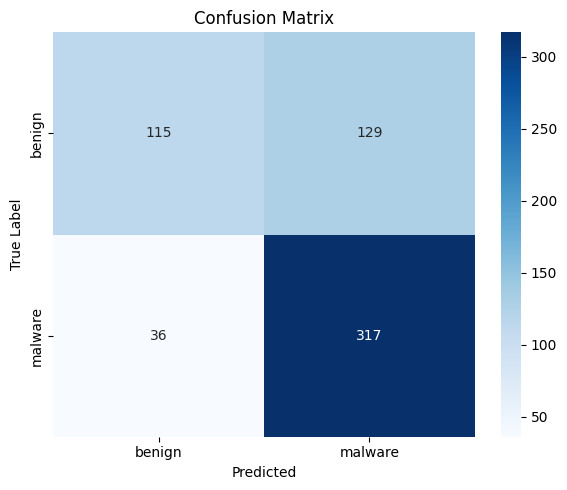


Classification Report:
              precision    recall  f1-score   support

      benign       0.76      0.47      0.58       244
     malware       0.71      0.90      0.79       353

    accuracy                           0.72       597
   macro avg       0.74      0.68      0.69       597
weighted avg       0.73      0.72      0.71       597



In [14]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        seq = batch["sequence"].to(device)
        num = batch["numeric"].to(device)
        lbl = batch["label"].to(device)

        logits = model(seq, num) if hasattr(model, "classifier") else model(seq)

        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:, 1]    # P(class=1)
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)

        all_preds .extend(preds.cpu().numpy())
        all_labels.extend(lbl.cpu().numpy())

print(f"– Dataset size: {len(test_loader.dataset)}")
print(f"– Collected preds: {len(all_preds)}, labels: {len(all_labels)}")

acc      = accuracy_score(all_labels, all_preds) * 100
f1_macro = f1_score(all_labels, all_preds, average="macro")
print(f"\nTest Accuracy : {acc:.2f}%")
print(f"Test F1-macro : {f1_macro:.4f}")

cm = confusion_matrix(all_labels, all_preds)
names = (le.classes_ if cfg.num_classes > 2 else ["benign","malware"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=names, yticklabels=names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=names))

In [15]:
# Quick debug - tambah print di awal evaluate_model
for batch in test_loader:
    seq = batch["sequence"]
    nums = batch["numeric"] 
    labels = batch["label"]
    
    print(f"seq shape: {seq.shape}")
    print(f"nums shape: {nums.shape}")  # <- ini yang penting
    print(f"labels shape: {labels.shape}")
    break

seq shape: torch.Size([64, 100])
nums shape: torch.Size([64, 2])
labels shape: torch.Size([64])


1. Single Feature Ablation
Starting Feature Ablation Study...
Baseline Accuracy: 0.7940
------------------------------
Testing without feature_0...
  Accuracy: 0.5913
  Importance: 0.2027

Testing without feature_1...
  Accuracy: 0.6516
  Importance: 0.1424


RESULTS SUMMARY:
  feature  accuracy  importance_score
 baseline  0.793970          0.000000
feature_0  0.591290          0.202680
feature_1  0.651591          0.142379

Top 3 Most Important Features:
  feature_0: 0.2027
  feature_1: 0.1424


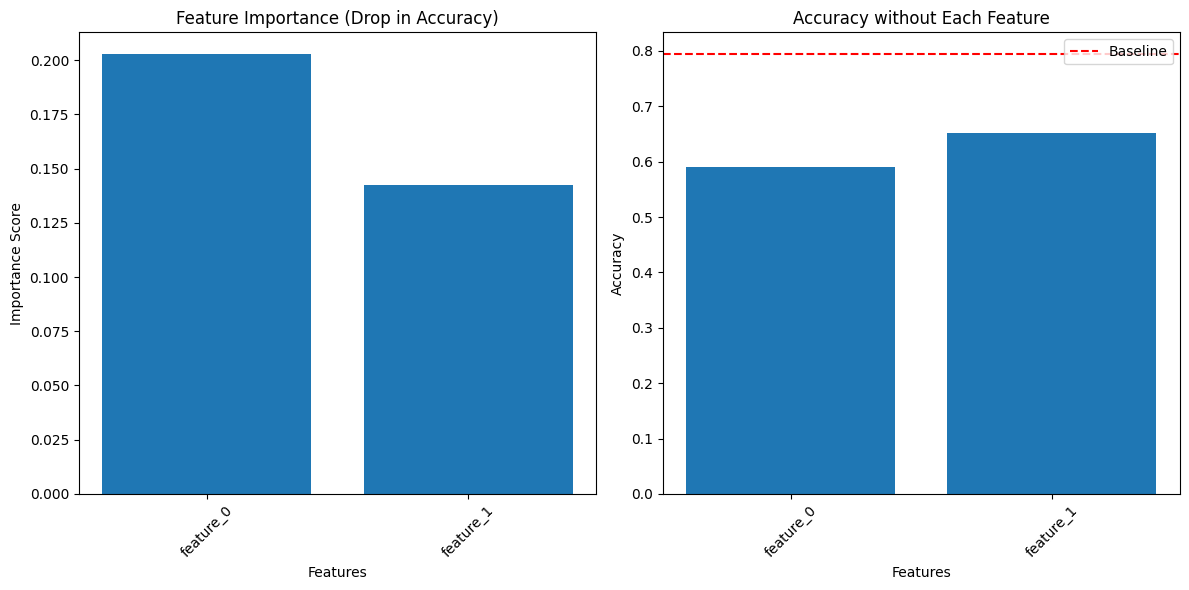


2. Progressive Ablation
Starting Progressive Ablation...
Step 1: Removed feature_1
  Accuracy: 0.6516
  Remaining: ['feature_0']



In [16]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

class FeatureAblationStudy:
    def __init__(self, model, test_loader, device, cfg, feature_names=None):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.cfg = cfg
        self.num_features = cfg.numeric_dim
        self.feature_names = feature_names or [f'feature_{i}' for i in range(self.num_features)]
        
    def evaluate_model(self, data_loader, ablate_feature=None):
        """Evaluate model dengan atau tanpa ablation"""
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in data_loader:
                # Unpack dictionary batch
                seq = batch["sequence"].to(self.device)
                nums = batch["numeric"].to(self.device)  # shape: (batch, max_length, numeric_dim)
                labels = batch["label"].to(self.device)
                
                # Apply ablation jika diperlukan
                if ablate_feature is not None:
                    nums_ablated = nums.clone()
                    # Handle different tensor dimensions
                    if nums.dim() == 3:  # (batch, seq_len, features)
                        nums_ablated[:, :, ablate_feature] = 0
                    elif nums.dim() == 2:  # (batch, features) - flattened
                        nums_ablated[:, ablate_feature] = 0
                    else:
                        raise ValueError(f"Unexpected nums tensor dimension: {nums.dim()}")
                    outputs = self.model(seq, nums_ablated)
                else:
                    outputs = self.model(seq, nums)
                
                # Untuk binary classification
                if outputs.shape[-1] == 1:
                    preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                # Untuk multiclass
                else:
                    preds = torch.argmax(outputs, dim=-1).cpu().numpy()
                
                all_preds.extend(preds.flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        
        accuracy = accuracy_score(all_labels, all_preds)
        return accuracy, all_preds, all_labels
    
    def run_ablation_study(self):
        """Jalankan ablation study untuk semua fitur"""
        print("Starting Feature Ablation Study...")
        print("="*50)
        
        # Baseline performance (tanpa ablation)
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        print(f"Baseline Accuracy: {baseline_acc:.4f}")
        print("-"*30)
        
        results = {
            'feature': ['baseline'],
            'accuracy': [baseline_acc],
            'importance_score': [0.0]
        }
        
        # Test setiap fitur
        for feature_idx in range(self.num_features):
            print(f"Testing without {self.feature_names[feature_idx]}...")
            
            # Evaluate tanpa fitur ini
            ablated_acc, _, _ = self.evaluate_model(
                self.test_loader, 
                ablate_feature=feature_idx
            )
            
            # Hitung importance score (penurunan akurasi)
            importance = baseline_acc - ablated_acc
            
            results['feature'].append(self.feature_names[feature_idx])
            results['accuracy'].append(ablated_acc)
            results['importance_score'].append(importance)
            
            print(f"  Accuracy: {ablated_acc:.4f}")
            print(f"  Importance: {importance:.4f}")
            print()
        
        return pd.DataFrame(results)
    
    def run_progressive_ablation(self):
        """Progressive ablation - hapus fitur satu per satu"""
        print("Starting Progressive Ablation...")
        print("="*50)
        
        remaining_features = list(range(self.num_features))
        removed_features = []
        results = []
        
        # Baseline
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        results.append({
            'step': 0,
            'removed_features': [],
            'remaining_features': remaining_features.copy(),
            'accuracy': baseline_acc
        })
        
        while len(remaining_features) > 1:
            best_to_remove = None
            best_accuracy = -1
            
            # Test menghilangkan setiap fitur yang tersisa
            for feature_idx in remaining_features:
                test_features = [f for f in remaining_features if f != feature_idx]
                
                # Create custom data loader dengan fitur yang di-mask
                masked_acc = self._evaluate_with_masked_features(
                    self.test_loader, 
                    keep_features=test_features
                )
                
                if masked_acc > best_accuracy:
                    best_accuracy = masked_acc
                    best_to_remove = feature_idx
            
            # Remove fitur dengan impact paling kecil
            remaining_features.remove(best_to_remove)
            removed_features.append(best_to_remove)
            
            results.append({
                'step': len(removed_features),
                'removed_feature': self.feature_names[best_to_remove],
                'remaining_features': [self.feature_names[f] for f in remaining_features],
                'accuracy': best_accuracy
            })
            
            print(f"Step {len(removed_features)}: Removed {self.feature_names[best_to_remove]}")
            print(f"  Accuracy: {best_accuracy:.4f}")
            print(f"  Remaining: {[self.feature_names[f] for f in remaining_features]}")
            print()
        
        return results
    
    def _evaluate_with_masked_features(self, data_loader, keep_features):
        """Helper untuk evaluate dengan hanya fitur tertentu"""
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in data_loader:
                # Unpack dictionary batch
                seq = batch["sequence"].to(self.device)
                nums = batch["numeric"].to(self.device)
                labels = batch["label"].to(self.device)
                
                # Mask semua fitur kecuali yang di keep_features
                nums_masked = torch.zeros_like(nums)
                for feature_idx in keep_features:
                    if nums.dim() == 3:  # (batch, seq_len, features)
                        nums_masked[:, :, feature_idx] = nums[:, :, feature_idx]
                    elif nums.dim() == 2:  # (batch, features)
                        nums_masked[:, feature_idx] = nums[:, feature_idx]
                
                outputs = self.model(seq, nums_masked)
                
                if outputs.shape[-1] == 1:
                    preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                else:
                    preds = torch.argmax(outputs, dim=-1).cpu().numpy()
                
                all_preds.extend(preds.flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        
        return accuracy_score(all_labels, all_preds)
    
    def plot_results(self, results_df):
        """Plot hasil ablation study"""
        import matplotlib.pyplot as plt
        
        # Sort by importance score
        results_sorted = results_df[results_df['feature'] != 'baseline'].sort_values(
            'importance_score', ascending=False
        )
        
        plt.figure(figsize=(12, 6))
        
        # Bar plot importance scores
        plt.subplot(1, 2, 1)
        plt.bar(results_sorted['feature'], results_sorted['importance_score'])
        plt.title('Feature Importance (Drop in Accuracy)')
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.xticks(rotation=45)
        
        # Accuracy comparison
        plt.subplot(1, 2, 2)
        plt.bar(results_sorted['feature'], results_sorted['accuracy'])
        plt.axhline(y=results_df[results_df['feature'] == 'baseline']['accuracy'].iloc[0], 
                   color='r', linestyle='--', label='Baseline')
        plt.title('Accuracy without Each Feature')
        plt.xlabel('Features')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Usage example:
def run_ablation_analysis(model, test_loader, cfg):
    """Main function untuk menjalankan ablation study"""
    
    # Define nama fitur sesuai cfg.numeric_dim
    feature_names = [f'feature_{i}' for i in range(cfg.numeric_dim)]
    # Atau bisa custom names:
    # feature_names = ['price', 'volume', 'sentiment', 'trend', 'volatility']  # contoh
    
    # Initialize ablation study
    ablation = FeatureAblationStudy(
        model=model,
        test_loader=test_loader,
        device=cfg.device,
        cfg=cfg,
        feature_names=feature_names
    )
    
    # Run single feature ablation
    print("1. Single Feature Ablation")
    results_df = ablation.run_ablation_study()
    
    # Print results
    print("\nRESULTS SUMMARY:")
    print("="*50)
    print(results_df.to_string(index=False))
    
    # Find most important features
    important_features = results_df[results_df['feature'] != 'baseline'].nlargest(3, 'importance_score')
    print(f"\nTop 3 Most Important Features:")
    for _, row in important_features.iterrows():
        print(f"  {row['feature']}: {row['importance_score']:.4f}")
    
    # Plot results
    ablation.plot_results(results_df)
    
    # Optional: Run progressive ablation
    print("\n2. Progressive Ablation")
    progressive_results = ablation.run_progressive_ablation()
    
    return results_df, progressive_results

# Cara pakai:
results, progressive = run_ablation_analysis(model, test_loader, cfg)

SEQUENCE ABLATION STUDY
Sequence length: 100
Analyzing timestep importance...

Running Single Timestep Ablation (method: zero)
Baseline Accuracy: 0.7940
----------------------------------------
Testing without timestep 0...
  Timestep 0: Acc=0.7940, Importance=0.0000
Testing without timestep 1...
Testing without timestep 2...
Testing without timestep 3...
Testing without timestep 4...
Testing without timestep 5...
Testing without timestep 6...
Testing without timestep 7...
Testing without timestep 8...
Testing without timestep 9...
Testing without timestep 10...
  Timestep 10: Acc=0.7940, Importance=0.0000
Testing without timestep 11...
Testing without timestep 12...
Testing without timestep 13...
Testing without timestep 14...
Testing without timestep 15...
Testing without timestep 16...
Testing without timestep 17...
Testing without timestep 18...
Testing without timestep 19...
Testing without timestep 20...
  Timestep 20: Acc=0.7940, Importance=0.0000
Testing without timestep 21...


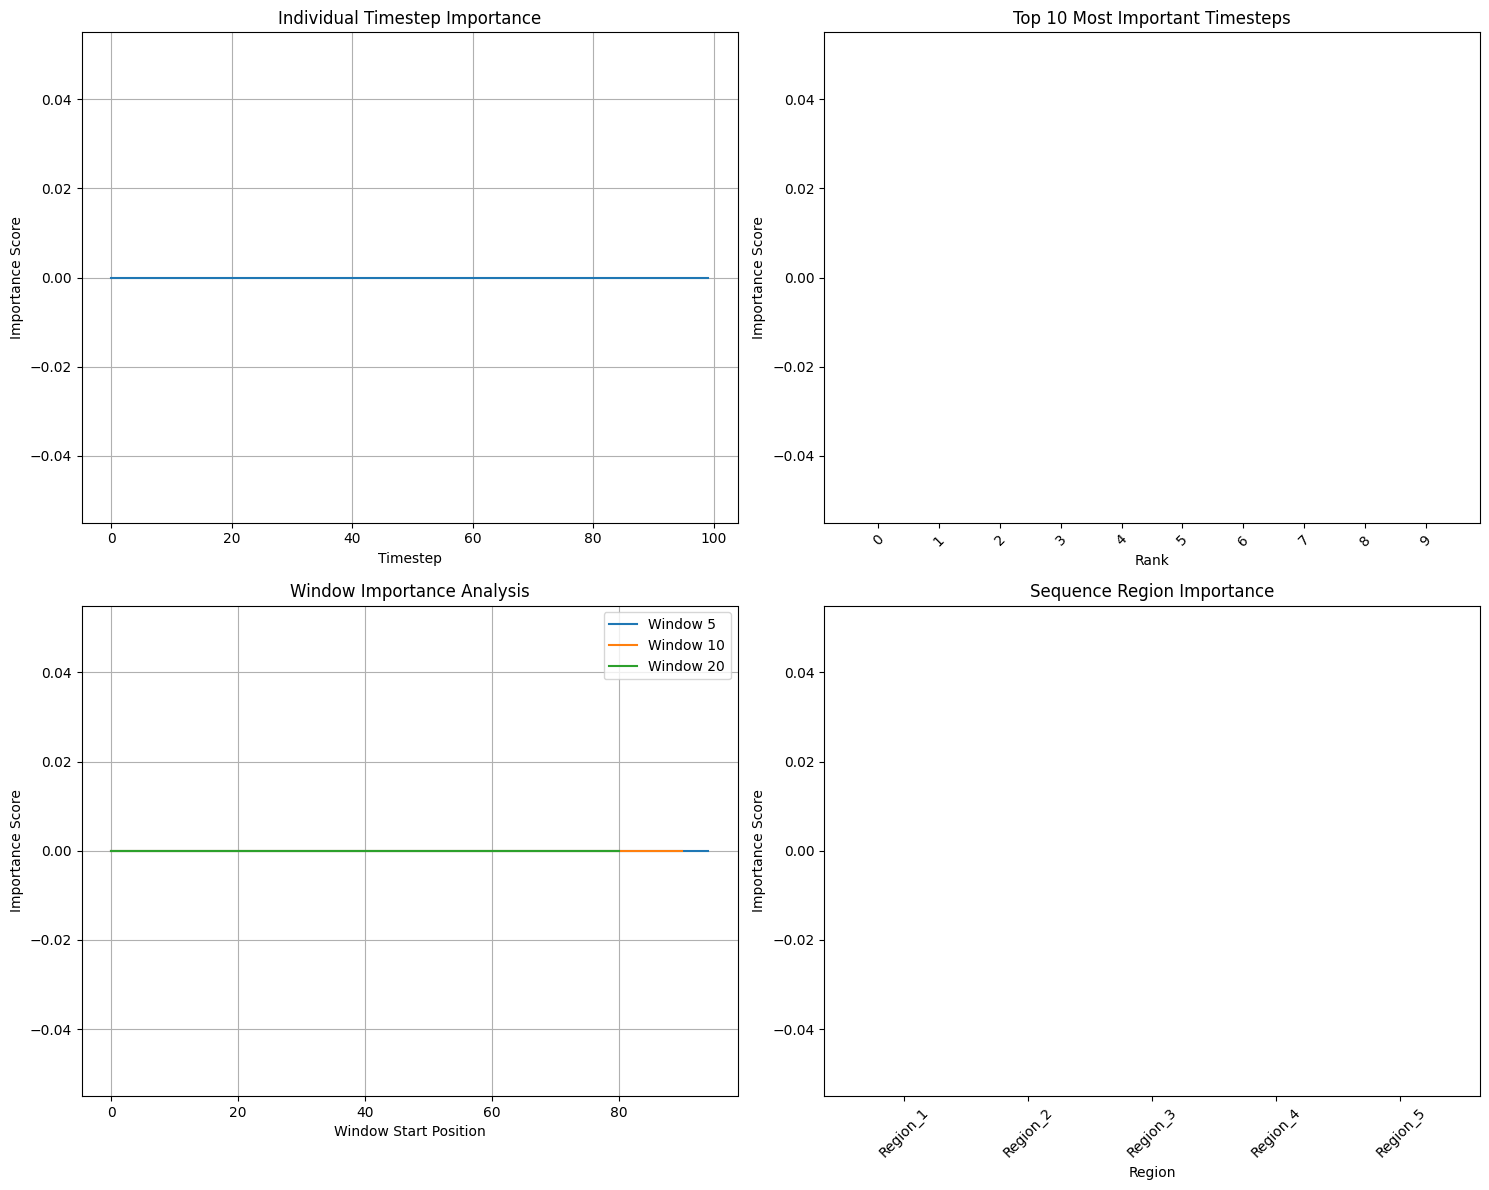

In [17]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

class SequenceAblationStudy:
    def __init__(self, model, test_loader, device, cfg):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.cfg = cfg
        self.seq_length = cfg.max_length  # 100 timesteps
        
    def evaluate_model(self, data_loader, ablate_timesteps=None, ablation_method='zero'):
        """
        Evaluate model dengan atau tanpa ablation pada timesteps tertentu
        
        ablate_timesteps: list of timestep indices to ablate
        ablation_method: 'zero', 'mean', atau 'noise'
        """
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in data_loader:
                seq = batch["sequence"].to(self.device)  # (batch, seq_len)
                nums = batch["numeric"].to(self.device)  # (batch, features)
                labels = batch["label"].to(self.device)
                
                # Apply ablation jika diperlukan
                if ablate_timesteps is not None:
                    seq_ablated = seq.clone()
                    
                    if ablation_method == 'zero':
                        # Set timestep tertentu jadi 0
                        seq_ablated[:, ablate_timesteps] = 0
                    elif ablation_method == 'mean':
                        # Set timestep jadi rata-rata sequence
                        seq_mean = seq.mean(dim=1, keepdim=True)
                        seq_ablated[:, ablate_timesteps] = seq_mean.expand(-1, len(ablate_timesteps))
                    elif ablation_method == 'noise':
                        # Set timestep jadi random noise
                        seq_ablated[:, ablate_timesteps] = torch.randn_like(seq_ablated[:, ablate_timesteps])
                    
                    outputs = self.model(seq_ablated, nums)
                else:
                    outputs = self.model(seq, nums)
                
                # Handle binary/multiclass prediction
                if outputs.shape[-1] == 1:
                    preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
                else:
                    preds = torch.argmax(outputs, dim=-1).cpu().numpy()
                
                all_preds.extend(preds.flatten())
                all_labels.extend(labels.cpu().numpy().flatten())
        
        accuracy = accuracy_score(all_labels, all_preds)
        return accuracy, all_preds, all_labels
    
    def run_single_timestep_ablation(self, ablation_method='zero'):
        """Test importance setiap timestep satu per satu"""
        print(f"Running Single Timestep Ablation (method: {ablation_method})")
        print("="*60)
        
        # Baseline performance
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        print(f"Baseline Accuracy: {baseline_acc:.4f}")
        print("-"*40)
        
        results = {
            'timestep': ['baseline'],
            'accuracy': [baseline_acc],
            'importance_score': [0.0]
        }
        
        # Test setiap timestep
        for t in range(self.seq_length):
            print(f"Testing without timestep {t}...")
            
            # Evaluate tanpa timestep ini
            ablated_acc, _, _ = self.evaluate_model(
                self.test_loader, 
                ablate_timesteps=[t],
                ablation_method=ablation_method
            )
            
            # Hitung importance score
            importance = baseline_acc - ablated_acc
            
            results['timestep'].append(f't_{t}')
            results['accuracy'].append(ablated_acc)
            results['importance_score'].append(importance)
            
            if t % 10 == 0 or importance > 0.01:  # Print yang penting atau setiap 10
                print(f"  Timestep {t}: Acc={ablated_acc:.4f}, Importance={importance:.4f}")
        
        return pd.DataFrame(results)
    
    def run_window_ablation(self, window_sizes=[5, 10, 20], ablation_method='zero'):
        """Test importance sliding windows dari timesteps"""
        print(f"Running Window Ablation (method: {ablation_method})")
        print("="*60)
        
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        print(f"Baseline Accuracy: {baseline_acc:.4f}")
        
        all_results = []
        
        for window_size in window_sizes:
            print(f"\nTesting window size: {window_size}")
            print("-"*30)
            
            step_size = max(1, window_size // 2)  # Overlap windows
            
            for start in range(0, self.seq_length - window_size + 1, step_size):
                end = start + window_size
                timesteps_to_ablate = list(range(start, end))
                
                # Evaluate tanpa window ini
                ablated_acc, _, _ = self.evaluate_model(
                    self.test_loader,
                    ablate_timesteps=timesteps_to_ablate,
                    ablation_method=ablation_method
                )
                
                importance = baseline_acc - ablated_acc
                
                all_results.append({
                    'window_size': window_size,
                    'start': start,
                    'end': end,
                    'window': f'{start}-{end}',
                    'accuracy': ablated_acc,
                    'importance_score': importance
                })
                
                if importance > 0.01:  # Print yang penting
                    print(f"  Window {start}-{end}: Acc={ablated_acc:.4f}, Importance={importance:.4f}")
        
        return pd.DataFrame(all_results)
    
    def run_progressive_timestep_removal(self):
        """Progressive removal - hapus timestep satu per satu dari yang paling tidak penting"""
        print("Running Progressive Timestep Removal")
        print("="*50)
        
        remaining_timesteps = list(range(self.seq_length))
        results = []
        
        # Baseline
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        results.append({
            'step': 0,
            'removed_timesteps': [],
            'num_remaining': len(remaining_timesteps),
            'accuracy': baseline_acc
        })
        
        # Remove timesteps progressively (ambil 10 step aja, karena 100 terlalu banyak)
        for step in range(min(20, self.seq_length - 10)):
            best_to_remove = None
            best_accuracy = -1
            
            # Test remove setiap timestep yang tersisa (sample beberapa aja)
            sample_timesteps = remaining_timesteps[::max(1, len(remaining_timesteps)//10)]
            
            for t in sample_timesteps:
                test_timesteps = [ts for ts in remaining_timesteps if ts != t]
                ablate_timesteps = [ts for ts in range(self.seq_length) if ts not in test_timesteps]
                
                acc, _, _ = self.evaluate_model(
                    self.test_loader,
                    ablate_timesteps=ablate_timesteps
                )
                
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_to_remove = t
            
            if best_to_remove is not None:
                remaining_timesteps.remove(best_to_remove)
                
                results.append({
                    'step': step + 1,
                    'removed_timestep': best_to_remove,
                    'num_remaining': len(remaining_timesteps),
                    'accuracy': best_accuracy
                })
                
                print(f"Step {step+1}: Removed timestep {best_to_remove}, Acc: {best_accuracy:.4f}")
        
        return results
    
    def analyze_sequence_regions(self, num_regions=5):
        """Bagi sequence jadi beberapa region dan test importance masing-masing"""
        print(f"Analyzing Sequence Regions (divided into {num_regions} parts)")
        print("="*60)
        
        baseline_acc, _, _ = self.evaluate_model(self.test_loader)
        print(f"Baseline Accuracy: {baseline_acc:.4f}")
        print("-"*40)
        
        region_size = self.seq_length // num_regions
        results = []
        
        for i in range(num_regions):
            start = i * region_size
            end = (i + 1) * region_size if i < num_regions - 1 else self.seq_length
            
            region_timesteps = list(range(start, end))
            
            # Test tanpa region ini
            ablated_acc, _, _ = self.evaluate_model(
                self.test_loader,
                ablate_timesteps=region_timesteps
            )
            
            importance = baseline_acc - ablated_acc
            
            results.append({
                'region': f'Region_{i+1}',
                'timesteps': f'{start}-{end}',
                'size': len(region_timesteps),
                'accuracy': ablated_acc,
                'importance_score': importance
            })
            
            print(f"Region {i+1} (t={start}-{end}): Acc={ablated_acc:.4f}, Importance={importance:.4f}")
        
        return pd.DataFrame(results)
    
    def plot_results(self, single_results, window_results=None, region_results=None):
        """Plot hasil ablation study"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Single timestep importance
        single_data = single_results[single_results['timestep'] != 'baseline']
        timesteps = range(len(single_data))
        
        axes[0,0].plot(timesteps, single_data['importance_score'])
        axes[0,0].set_title('Individual Timestep Importance')
        axes[0,0].set_xlabel('Timestep')
        axes[0,0].set_ylabel('Importance Score')
        axes[0,0].grid(True)
        
        # 2. Top important timesteps
        top_timesteps = single_data.nlargest(10, 'importance_score')
        axes[0,1].bar(range(len(top_timesteps)), top_timesteps['importance_score'])
        axes[0,1].set_title('Top 10 Most Important Timesteps')
        axes[0,1].set_xlabel('Rank')
        axes[0,1].set_ylabel('Importance Score')
        axes[0,1].set_xticks(range(len(top_timesteps)))
        axes[0,1].set_xticklabels([t.replace('t_', '') for t in top_timesteps['timestep']], rotation=45)
        
        # 3. Window analysis (if available)
        if window_results is not None:
            for window_size in window_results['window_size'].unique():
                data = window_results[window_results['window_size'] == window_size]
                axes[1,0].plot(data['start'], data['importance_score'], label=f'Window {window_size}')
            axes[1,0].set_title('Window Importance Analysis')
            axes[1,0].set_xlabel('Window Start Position')
            axes[1,0].set_ylabel('Importance Score')
            axes[1,0].legend()
            axes[1,0].grid(True)
        
        # 4. Region analysis (if available)
        if region_results is not None:
            axes[1,1].bar(region_results['region'], region_results['importance_score'])
            axes[1,1].set_title('Sequence Region Importance')
            axes[1,1].set_xlabel('Region')
            axes[1,1].set_ylabel('Importance Score')
            axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

def run_sequence_ablation_analysis(model, test_loader, cfg):
    """Main function untuk sequence ablation study"""
    
    ablation = SequenceAblationStudy(model, test_loader, cfg.device, cfg)
    
    print("SEQUENCE ABLATION STUDY")
    print("="*70)
    print(f"Sequence length: {cfg.max_length}")
    print(f"Analyzing timestep importance...")
    print()
    
    # 1. Single timestep ablation
    single_results = ablation.run_single_timestep_ablation(ablation_method='zero')
    
    # 2. Region analysis
    region_results = ablation.analyze_sequence_regions(num_regions=5)
    
    # 3. Window analysis
    window_results = ablation.run_window_ablation(window_sizes=[5, 10, 20])
    
    # Print summaries
    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    
    # Top important timesteps
    top_timesteps = single_results[single_results['timestep'] != 'baseline'].nlargest(5, 'importance_score')
    print("\nTop 5 Most Important Timesteps:")
    for _, row in top_timesteps.iterrows():
        print(f"  {row['timestep']}: {row['importance_score']:.4f}")
    
    # Most important region
    best_region = region_results.loc[region_results['importance_score'].idxmax()]
    print(f"\nMost Important Region: {best_region['region']} ({best_region['timesteps']})")
    print(f"  Importance Score: {best_region['importance_score']:.4f}")
    
    # Best window
    best_window = window_results.loc[window_results['importance_score'].idxmax()]
    print(f"\nMost Important Window: {best_window['window']} (size {best_window['window_size']})")
    print(f"  Importance Score: {best_window['importance_score']:.4f}")
    
    # Plot results
    ablation.plot_results(single_results, window_results, region_results)
    
    return {
        'single_timestep': single_results,
        'regions': region_results, 
        'windows': window_results
    }

# Usage:
results = run_sequence_ablation_analysis(model, test_loader, cfg)

In [18]:
# Test baseline
for batch in test_loader:
    seq = batch["sequence"]
    nums = batch["numeric"] 
    labels = batch["label"]
    
    print(f"Sample sequence values: {seq[0][:10]}")  # first 10 timesteps
    print(f"Sequence mean: {seq.mean():.4f}")
    print(f"Sequence std: {seq.std():.4f}")
    break

Sample sequence values: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [ ]:
def analyze_sequence_variance(test_loader):
    all_sequences = []
    
    for batch in test_loader:
        seq = batch["sequence"].float()  # <- TAMBAH .float()
        all_sequences.append(seq)
    
    all_seq = torch.cat(all_sequences, dim=0)
    timestep_variance = all_seq.var(dim=0)
    timestep_mean = all_seq.mean(dim=0)
    
    # Ranking berdasarkan variance
    variance_ranking = torch.argsort(timestep_variance, descending=True)
    
    print("Top 10 timesteps dengan variance tertinggi:")
    for i in range(10):
        t = variance_ranking[i].item()
        print(f"Timestep {t}: var={timestep_variance[t]:.4f}, mean={timestep_mean[t]:.4f}")
    
    return timestep_variance, variance_ranking

variance, ranking = analyze_sequence_variance(test_loader)

In [ ]:
def analyze_timestep_class_separation(test_loader):
    sequences_by_class = {}
    
    for batch in test_loader:
        seq = batch["sequence"]  # (batch, 100)
        labels = batch["label"]
        
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in sequences_by_class:
                sequences_by_class[label] = []
            sequences_by_class[label].append(seq[i])
    
    # Convert to tensors
    for label in sequences_by_class:
        sequences_by_class[label] = torch.stack(sequences_by_class[label])
    
    # T-test or KS test per timestep
    from scipy.stats import ttest_ind
    
    classes = list(sequences_by_class.keys())
    if len(classes) == 2:  # Binary classification
        class0_data = sequences_by_class[classes[0]].numpy()
        class1_data = sequences_by_class[classes[1]].numpy()
        
        timestep_pvalues = []
        timestep_stats = []
        
        for t in range(100):
            stat, pval = ttest_ind(class0_data[:, t], class1_data[:, t])
            timestep_pvalues.append(pval)
            timestep_stats.append(abs(stat))
        
        # Ranking berdasarkan statistical significance
        stat_ranking = np.argsort(timestep_pvalues)  # ascending p-value
        
        print("Top 10 timesteps paling berbeda antar class:")
        for i in range(10):
            t = stat_ranking[i]
            print(f"Timestep {t}: p-value={timestep_pvalues[t]:.6f}, t-stat={timestep_stats[t]:.4f}")
        
        return timestep_pvalues, stat_ranking

pvalues, stat_ranking = analyze_timestep_class_separation(test_loader)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def analyze_mutual_information(test_loader):
    all_sequences = []
    all_labels = []
    
    for batch in test_loader:
        seq = batch["sequence"]
        labels = batch["label"]
        all_sequences.append(seq)
        all_labels.append(labels)
    
    X = torch.cat(all_sequences, dim=0).numpy()  # (samples, 100)
    y = torch.cat(all_labels, dim=0).numpy()
    
    # Mutual information per timestep
    mi_scores = mutual_info_classif(X, y, random_state=42)
    mi_ranking = np.argsort(mi_scores)[::-1]  # descending
    
    print("Top 10 timesteps dengan MI tertinggi:")
    for i in range(10):
        t = mi_ranking[i]
        print(f"Timestep {t}: MI={mi_scores[t]:.4f}")
    
    return mi_scores, mi_ranking

mi_scores, mi_ranking = analyze_mutual_information(test_loader)

In [ ]:
def analyze_sequence_gradients(model, test_loader, cfg):
    model.eval()
    all_gradients = []
    
    for batch in test_loader:
        seq = batch["sequence"].to(cfg.device)
        nums = batch["numeric"].to(cfg.device)
        labels = batch["label"].to(cfg.device)
        
        seq.requires_grad_(True)
        
        outputs = model(seq, nums)
        
        # Compute gradients
        if outputs.shape[-1] == 1:
            loss = torch.sigmoid(outputs).sum()
        else:
            loss = outputs.max(dim=-1)[0].sum()
        
        loss.backward()
        
        # Gradient magnitude per timestep
        grad_magnitude = seq.grad.abs().mean(dim=0)  # (100,)
        all_gradients.append(grad_magnitude.detach().cpu())
        
        seq.grad.zero_()
        
        break  # cuma sample beberapa batch
    
    avg_gradients = torch.stack(all_gradients).mean(dim=0)
    gradient_ranking = torch.argsort(avg_gradients, descending=True)
    
    print("Top 10 timesteps dengan gradient tertinggi:")
    for i in range(10):
        t = gradient_ranking[i].item()
        print(f"Timestep {t}: gradient={avg_gradients[t]:.6f}")
    
    return avg_gradients, gradient_ranking

gradients, grad_ranking = analyze_sequence_gradients(model, test_loader, cfg)

In [ ]:
# Lihat sample data mentah
for batch in test_loader:
    seq = batch["sequence"]
    print("Sample data:")
    print(f"First sample, first 15 timesteps: {seq[0][:15]}")
    print(f"First sample, last 15 timesteps: {seq[0][-15:]}")
    print(f"Unique values in first 10 timesteps: {torch.unique(seq[:, :10])}")
    print(f"Unique values in last 10 timesteps: {torch.unique(seq[:, -10:])}")
    break